# **0. Setting Google Drive**

In [1]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
dir_name = 'AI_Chem/Generation_with_VAE_4'  # path to the folder you made starting from your google drive home directory.
if dir_name[0] == '/': dir_name = dir_name[1:]
if dir_name[-1] == '/': dir_name = dir_name[:-1]
os.chdir(f'/content/gdrive/MyDrive/{dir_name}/')
os.listdir(os.getcwd()) 

['assignment_4_template.ipynb',
 'assignment_4_question.pdf',
 'smiles_4.txt',
 'save']

In [7]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 59.7 MB/s eta 0:00:00


In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP
from functools import reduce # optional
from tqdm import tqdm # optional
import numpy as np

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **1. Defining Dataset**

In [9]:
class MolDataset(Dataset):

    def __init__(self, smi_list):
        super().__init__()
        self.smi_list = smi_list

        self._set_c_to_i()
        self._set_i_to_c()
        self.vec_dim = self._get_num_char()
      
    def __len__(self):
        return len(self.smi_list)

    def __getitem__(self, idx):
        '''
        returns a dict of {"input": input, "output": output, "length", length},
        where input is a long tensor of seq. encoded smiles,
        output is a float tensor of corresponding logp value, and
        length is a long tensor of "a length of smiles".
        '''
        sample = dict()
        smi = self.smi_list[idx]
        
        input = self._encode_smi(smi)
        logp = self._get_logp(smi)

        sample = {
                "input": torch.LongTensor(input),
                "length": torch.LongTensor([len(smi) + 1]), ### +1 due to <EOS>
                "logp": torch.Tensor(logp)
        }
        return sample

    def _set_c_to_i(self):
        '''
        Obtains c_to_i dictionary from smi_list.
        
        '''
        whole_char = ['X'] ##### auxiliary token, padding_value = 0
        whole_char += list(reduce(lambda x, y: x | y, \
                [set(smi) for smi in self.smi_list]))
        c_to_i = {c: i for i, c in enumerate(whole_char)}
        self.c_to_i = c_to_i

    def _set_i_to_c(self):
        self.i_to_c = {v:k for k, v in self.c_to_i.items()}

    def _get_c_to_i(self):
        return self.c_to_i

    def _get_i_to_c(self):
        return self.i_to_c

    def _encode_smi(self, smi):
        return np.array([self.c_to_i[c] for c in smi + 'X'])

    def _get_num_char(self):
        return len(getattr(self, "c_to_i", dict()))
    
    def _get_logp(self, smi):
        '''
        returns a numpy array of logP of given smiles.
        '''
        mol = Chem.MolFromSmiles(smi)
        return np.array([MolLogP(mol)])

In [10]:
def random_splitter(dataset, train_ratio, validation_ratio, test_ratio):
    import random
    import copy
    assert train_ratio + validation_ratio + test_ratio == 1.0
    N = len(dataset)
    all_idx = list(range(N))
    random.shuffle(all_idx)

    train_idx = all_idx[:int(train_ratio * N)]
    valid_idx = all_idx[int(train_ratio * N):int(validation_ratio * N) \
                        + int(train_ratio * N)]
    test_idx = all_idx[int(validation_ratio * N) + int(train_ratio * N):]
    train_dataset = copy.deepcopy(dataset)
    valid_dataset = copy.deepcopy(dataset)
    test_dataset  = copy.deepcopy(dataset)
    train_dataset.smi_list = [dataset.smi_list[i] for i in train_idx]
    valid_dataset.smi_list = [dataset.smi_list[i] for i in valid_idx]
    test_dataset.smi_list =  [dataset.smi_list[i] for i in  test_idx]
    return train_dataset, valid_dataset, test_dataset 

In [11]:
def sample_collate_fn(samples):
    '''
    Dataloader will make a list of samples with a len(samples) = batch_size.
    Collate function pads all the tensors in every sample at maximum size,
    and stack them on a batch dimension.

    Example)
    if four tensors of shape (3, 7), (2, 7), (6, 7), (4, 7) is given,
    collated tensor will have a shape of (4, 6, 7) where 4 is a batch size.
    '''
    inputs = pad_sequence([sample["input"] for sample in samples], \
            batch_first=True, padding_value=0)
    lengths = torch.cat([sample["length"] for sample in samples], dim=0)
    logps = torch.cat([sample["logp"] for sample in samples], dim=0)

    sample_batch = {
            "input": inputs,
            "length": lengths,
            "logp": logps
    }
    return sample_batch

In [ ]:
sample_smi_list = ["c1ccccc1", "COCC", "CCCCCCCCCCCCN"]

sample_dataset = MolDataset(sample_smi_list)
print(sample_dataset.c_to_i)
print(sample_dataset.i_to_c)
print(sample_dataset[1])
print(sample_dataset._get_num_char())

{'X': 0, 'c': 1, 'O': 2, '1': 3, 'N': 4, 'C': 5}
{0: 'X', 1: 'c', 2: 'O', 3: '1', 4: 'N', 5: 'C'}
{'input': tensor([5, 2, 5, 5, 0]), 'length': tensor([5]), 'logp': tensor([0.6527])}
6


# **2. Defining VAE Model**

In [12]:
class VariationalAutoEncoder(nn.Module):
    
    def __init__(
            self, 
            n_char,
            n_hidden,
            n_rnn_layer
            ):
        super().__init__()

        self.n_char = n_char
        self.n_hidden = n_hidden
        self.n_rnn_layer = n_rnn_layer

        self.sos = nn.Parameter(torch.ones(1, 1, n_hidden))
        self.sos.requires_grad = False
        
        self.embedding = nn.Embedding(n_char, n_hidden)
        self.encoder = nn.GRU(input_size=n_hidden, hidden_size=n_hidden, \
                          num_layers=n_rnn_layer, batch_first=True)
        self.decoder = nn.GRU(input_size=n_hidden, hidden_size=n_hidden, \
                          num_layers=n_rnn_layer, batch_first=True)
        self.mu_layer = nn.Linear(n_hidden, n_hidden)
        self.logvar_layer = nn.Linear(n_hidden, n_hidden)
        self.final_layer = nn.Linear(n_hidden, n_char)

        self.rec_loss_fn = nn.CrossEntropyLoss()
        self.vae_loss_fn = self.vae_loss

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        return mu + eps * std

    def vae_loss(self, mu, logvar):
        return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    def forward(self, x, length):    
        '''
        x (torch.Tensor): [B, L]
        '''            
        B = x.shape[0] # batch size     

        # 1. Embedding x[B L] -> h[B L F]  
        h = self.embedding(x) # [B L F]

        # 2. Encoder h[B L F] -> enc[B L F] -> z[B F]
        enc, _ = self.encoder(h) # [B L F]
        z = torch.stack([enc[i, length[i] - 1, :] for i in range(B)], dim=0) # [B F]

        # 3. Getting mu and logvar from z and reparameterizes it
        mu = self.mu_layer(z)
        logvar = self.logvar_layer(z)
        rep_z = self.reparameterize(mu, logvar)

        # 4. Decoder z[B F], dec_in[B 1+L F] -> dec[B 1+L F]
        sos_vec = self.sos.repeat(B, 1, 1) # [B 1 F]
        dec_in = torch.cat([sos_vec, h], dim=1) # [B 1+L F]
        dec, _ = self.decoder(dec_in, rep_z.unsqueeze(0).repeat(self.n_rnn_layer, 1, 1))
        
        # 5. Predicting the probability of character dec[B 1+L F] -> dec_final[B 1+L N_CHAR]
        dec_final = self.final_layer(dec) # [B 1+L N_CHAR]

        # 6. Calculating loss
        rec_losses = torch.stack(
            [self.rec_loss_fn(dec_final[i, :length[i], :], x[i, :length[i]]) \
             / length[i] for i in range(B)], dim=0
        ) # length due to <SOS>
        rec_loss = rec_losses.mean()
        vae_loss = self.vae_loss_fn(mu, logvar)

        loss = rec_loss + vae_loss
        return loss, rec_loss, vae_loss

    def generate(self, max_length, batch_size=1):
        z = torch.randn(self.n_rnn_layer, batch_size, self.n_hidden).to(self.sos.device)
        dec_in = self.sos.repeat(batch_size, 1, 1) # [B 1 F]

        gen_smis = []
        i = 0
        while i < max_length:
            dec_out, z = self.decoder(dec_in, z)
            dec_final = nn.functional.softmax(self.final_layer(dec_out), dim=-1)
            index = torch.argmax(dec_final)

            if index == 0: break # <eos>
            gen_smis.append(int(index))
            dec_in = self.embedding(index.view(1, -1).long())
            i += 1
        if i == max_length: return [] # generation failed
        return gen_smis

In [ ]:
dataloader = DataLoader(sample_dataset, batch_size=3, shuffle=False, collate_fn=sample_collate_fn)
dataiter = iter(dataloader)
batch = next(dataiter) 
print(batch)

sample_model = VariationalAutoEncoder(6, 64, 1)
loss, rec_loss, vae_loss = sample_model(batch["input"], batch["length"])
print(loss)
print(rec_loss)
print(vae_loss)

{'input': tensor([[1, 3, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0],
        [5, 2, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 0]]), 'length': tensor([ 9,  5, 14]), 'logp': tensor([1.6866, 0.6527, 3.8660])}
tensor(0.2828, grad_fn=<AddBackward0>)
tensor(0.2516, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MulBackward0>)


# **3. Hyperparameter Settings**

In [13]:
########## DO NOT CHANGE ##########
NUM_EPOCH = 100
LR = 1e-4
N_HIDDEN = 128
N_RNN_LAYER = 1
BATCH_SIZE = 64
DATA_DIR = "./smiles_4.txt"
####################################

# **4. Building the Dataset**

In [ ]:
with open(DATA_DIR, 'r') as f:
    smi_list = [l.strip() for l in f.readlines()]

dataset = MolDataset(smi_list)
train_dataset, valid_dataset, test_dataset = \
        random_splitter(dataset, 0.8, 0.2, 0.0)

N_CHAR = dataset._get_num_char()

# **5. Building the DataLoader**

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=sample_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=sample_collate_fn)
tr_N = len(train_dataset)
va_N = len(valid_dataset)

# **6. Setting Model and Optimizer**

In [ ]:
model = VariationalAutoEncoder(
            N_CHAR,
            N_HIDDEN,
            N_RNN_LAYER
        )
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model = model.to(device)

# **7. Training with Mini-batches**

In [ ]:
save_dir = "./save/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

train_loss_history, valid_loss_history = [], []
best_loss = 1e6
for i in range(1, NUM_EPOCH + 1):

    model.train()
    train_batch_losses = []
    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=tr_N // BATCH_SIZE):
        x_batch = batch["input"].long().to(device)
        l_batch = batch["length"].long().to(device)

        loss, rec_loss, vae_loss = model(x_batch, l_batch)
        train_batch_losses.append(loss.data.cpu().numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=va_N // BATCH_SIZE):
            x_batch = batch["input"].long().to(device)
            l_batch = batch["length"].long().to(device)

            loss, rec_loss, vae_loss = model(x_batch, l_batch)
            valid_batch_losses.append(loss.data.cpu().numpy())

    train_avg_loss = np.mean(np.array(train_batch_losses))
    valid_avg_loss = np.mean(np.array(valid_batch_losses))
    train_loss_history.append(train_avg_loss)
    valid_loss_history.append(valid_avg_loss)
    
    if valid_avg_loss < best_loss:
        best_epoch = i
        best_loss = valid_avg_loss

    print(f"\t{i}th EPOCH --- TRAIN LOSS: {train_avg_loss:.4f} || VALIDATION LOSS: {valid_avg_loss:.4f} || BEST EPOCH: {best_epoch}", flush=True)

    torch.save(model.state_dict(), os.path.join(save_dir, f"save_{i}.pt"))

100%|██████████| 125/125 [00:11<00:00, 10.94it/s]
32it [00:01, 24.60it/s]                        

	1th EPOCH --- TRAIN LOSS: 0.0730 || VALIDATION LOSS: 0.0568 || BEST EPOCH: 1



100%|██████████| 125/125 [00:07<00:00, 16.22it/s]
32it [00:01, 24.51it/s]                        

	2th EPOCH --- TRAIN LOSS: 0.0508 || VALIDATION LOSS: 0.0480 || BEST EPOCH: 2



100%|██████████| 125/125 [00:07<00:00, 16.06it/s]
32it [00:01, 24.33it/s]                        

	3th EPOCH --- TRAIN LOSS: 0.0448 || VALIDATION LOSS: 0.0435 || BEST EPOCH: 3



100%|██████████| 125/125 [00:07<00:00, 16.10it/s]
32it [00:01, 24.64it/s]                        

	4th EPOCH --- TRAIN LOSS: 0.0411 || VALIDATION LOSS: 0.0402 || BEST EPOCH: 4



100%|██████████| 125/125 [00:07<00:00, 16.24it/s]
32it [00:01, 24.57it/s]                        

	5th EPOCH --- TRAIN LOSS: 0.0382 || VALIDATION LOSS: 0.0376 || BEST EPOCH: 5



100%|██████████| 125/125 [00:07<00:00, 15.99it/s]
32it [00:01, 24.62it/s]                        

	6th EPOCH --- TRAIN LOSS: 0.0359 || VALIDATION LOSS: 0.0356 || BEST EPOCH: 6



100%|██████████| 125/125 [00:07<00:00, 16.09it/s]
32it [00:01, 24.16it/s]                        

	7th EPOCH --- TRAIN LOSS: 0.0341 || VALIDATION LOSS: 0.0339 || BEST EPOCH: 7



100%|██████████| 125/125 [00:08<00:00, 14.83it/s]
32it [00:01, 24.29it/s]                        

	8th EPOCH --- TRAIN LOSS: 0.0325 || VALIDATION LOSS: 0.0325 || BEST EPOCH: 8



100%|██████████| 125/125 [00:07<00:00, 16.13it/s]
32it [00:01, 24.13it/s]                        

	9th EPOCH --- TRAIN LOSS: 0.0313 || VALIDATION LOSS: 0.0314 || BEST EPOCH: 9



100%|██████████| 125/125 [00:08<00:00, 14.96it/s]
32it [00:01, 24.79it/s]                        

	10th EPOCH --- TRAIN LOSS: 0.0304 || VALIDATION LOSS: 0.0305 || BEST EPOCH: 10



100%|██████████| 125/125 [00:07<00:00, 16.23it/s]
32it [00:01, 24.56it/s]                        

	11th EPOCH --- TRAIN LOSS: 0.0295 || VALIDATION LOSS: 0.0297 || BEST EPOCH: 11



100%|██████████| 125/125 [00:07<00:00, 16.01it/s]
32it [00:01, 24.39it/s]                        

	12th EPOCH --- TRAIN LOSS: 0.0288 || VALIDATION LOSS: 0.0290 || BEST EPOCH: 12



100%|██████████| 125/125 [00:07<00:00, 16.29it/s]
32it [00:01, 24.61it/s]                        

	13th EPOCH --- TRAIN LOSS: 0.0281 || VALIDATION LOSS: 0.0284 || BEST EPOCH: 13



100%|██████████| 125/125 [00:07<00:00, 16.11it/s]
32it [00:01, 24.97it/s]                        

	14th EPOCH --- TRAIN LOSS: 0.0275 || VALIDATION LOSS: 0.0279 || BEST EPOCH: 14



100%|██████████| 125/125 [00:07<00:00, 16.05it/s]
32it [00:01, 24.32it/s]                        

	15th EPOCH --- TRAIN LOSS: 0.0270 || VALIDATION LOSS: 0.0274 || BEST EPOCH: 15



100%|██████████| 125/125 [00:07<00:00, 16.03it/s]
32it [00:01, 24.07it/s]                        

	16th EPOCH --- TRAIN LOSS: 0.0265 || VALIDATION LOSS: 0.0269 || BEST EPOCH: 16



100%|██████████| 125/125 [00:07<00:00, 16.18it/s]
32it [00:01, 24.42it/s]                        

	17th EPOCH --- TRAIN LOSS: 0.0261 || VALIDATION LOSS: 0.0265 || BEST EPOCH: 17



100%|██████████| 125/125 [00:07<00:00, 16.00it/s]
32it [00:01, 24.42it/s]                        

	18th EPOCH --- TRAIN LOSS: 0.0257 || VALIDATION LOSS: 0.0261 || BEST EPOCH: 18



100%|██████████| 125/125 [00:07<00:00, 16.25it/s]
32it [00:01, 24.42it/s]                        

	19th EPOCH --- TRAIN LOSS: 0.0253 || VALIDATION LOSS: 0.0257 || BEST EPOCH: 19



100%|██████████| 125/125 [00:07<00:00, 16.29it/s]
32it [00:01, 24.55it/s]                        

	20th EPOCH --- TRAIN LOSS: 0.0249 || VALIDATION LOSS: 0.0253 || BEST EPOCH: 20



100%|██████████| 125/125 [00:07<00:00, 16.15it/s]
32it [00:01, 24.53it/s]                        

	21th EPOCH --- TRAIN LOSS: 0.0245 || VALIDATION LOSS: 0.0250 || BEST EPOCH: 21



100%|██████████| 125/125 [00:07<00:00, 16.22it/s]
32it [00:01, 24.81it/s]                        

	22th EPOCH --- TRAIN LOSS: 0.0242 || VALIDATION LOSS: 0.0247 || BEST EPOCH: 22



100%|██████████| 125/125 [00:07<00:00, 16.22it/s]
32it [00:01, 24.47it/s]                        

	23th EPOCH --- TRAIN LOSS: 0.0239 || VALIDATION LOSS: 0.0244 || BEST EPOCH: 23



100%|██████████| 125/125 [00:07<00:00, 15.96it/s]
32it [00:01, 24.44it/s]                        

	24th EPOCH --- TRAIN LOSS: 0.0237 || VALIDATION LOSS: 0.0242 || BEST EPOCH: 24



100%|██████████| 125/125 [00:07<00:00, 16.27it/s]
32it [00:01, 24.20it/s]                        

	25th EPOCH --- TRAIN LOSS: 0.0234 || VALIDATION LOSS: 0.0240 || BEST EPOCH: 25



100%|██████████| 125/125 [00:07<00:00, 16.19it/s]
32it [00:01, 24.41it/s]                        

	26th EPOCH --- TRAIN LOSS: 0.0232 || VALIDATION LOSS: 0.0237 || BEST EPOCH: 26



100%|██████████| 125/125 [00:07<00:00, 16.18it/s]
32it [00:01, 24.45it/s]                        

	27th EPOCH --- TRAIN LOSS: 0.0230 || VALIDATION LOSS: 0.0235 || BEST EPOCH: 27



100%|██████████| 125/125 [00:07<00:00, 16.19it/s]
32it [00:01, 24.28it/s]                        

	28th EPOCH --- TRAIN LOSS: 0.0227 || VALIDATION LOSS: 0.0233 || BEST EPOCH: 28



100%|██████████| 125/125 [00:07<00:00, 16.22it/s]
32it [00:01, 24.49it/s]                        

	29th EPOCH --- TRAIN LOSS: 0.0226 || VALIDATION LOSS: 0.0232 || BEST EPOCH: 29



100%|██████████| 125/125 [00:08<00:00, 14.17it/s]
32it [00:01, 24.29it/s]                        

	30th EPOCH --- TRAIN LOSS: 0.0224 || VALIDATION LOSS: 0.0230 || BEST EPOCH: 30



100%|██████████| 125/125 [00:07<00:00, 16.12it/s]
32it [00:01, 24.31it/s]                        

	31th EPOCH --- TRAIN LOSS: 0.0222 || VALIDATION LOSS: 0.0229 || BEST EPOCH: 31



100%|██████████| 125/125 [00:07<00:00, 16.09it/s]
32it [00:01, 24.72it/s]                        

	32th EPOCH --- TRAIN LOSS: 0.0220 || VALIDATION LOSS: 0.0227 || BEST EPOCH: 32



100%|██████████| 125/125 [00:07<00:00, 16.15it/s]
32it [00:01, 24.38it/s]                        

	33th EPOCH --- TRAIN LOSS: 0.0219 || VALIDATION LOSS: 0.0226 || BEST EPOCH: 33



100%|██████████| 125/125 [00:07<00:00, 16.19it/s]
32it [00:01, 24.76it/s]                        

	34th EPOCH --- TRAIN LOSS: 0.0217 || VALIDATION LOSS: 0.0224 || BEST EPOCH: 34



100%|██████████| 125/125 [00:07<00:00, 16.23it/s]
32it [00:01, 24.49it/s]                        

	35th EPOCH --- TRAIN LOSS: 0.0216 || VALIDATION LOSS: 0.0223 || BEST EPOCH: 35



100%|██████████| 125/125 [00:07<00:00, 16.01it/s]
32it [00:01, 24.58it/s]                        

	36th EPOCH --- TRAIN LOSS: 0.0214 || VALIDATION LOSS: 0.0222 || BEST EPOCH: 36



100%|██████████| 125/125 [00:07<00:00, 16.18it/s]
32it [00:01, 24.64it/s]                        

	37th EPOCH --- TRAIN LOSS: 0.0213 || VALIDATION LOSS: 0.0220 || BEST EPOCH: 37



100%|██████████| 125/125 [00:07<00:00, 16.09it/s]
32it [00:01, 24.81it/s]                        

	38th EPOCH --- TRAIN LOSS: 0.0212 || VALIDATION LOSS: 0.0219 || BEST EPOCH: 38



100%|██████████| 125/125 [00:07<00:00, 16.15it/s]
32it [00:01, 24.32it/s]                        

	39th EPOCH --- TRAIN LOSS: 0.0211 || VALIDATION LOSS: 0.0218 || BEST EPOCH: 39



100%|██████████| 125/125 [00:07<00:00, 16.00it/s]
32it [00:01, 24.14it/s]                        

	40th EPOCH --- TRAIN LOSS: 0.0209 || VALIDATION LOSS: 0.0217 || BEST EPOCH: 40



100%|██████████| 125/125 [00:07<00:00, 16.28it/s]
32it [00:01, 24.63it/s]                        

	41th EPOCH --- TRAIN LOSS: 0.0208 || VALIDATION LOSS: 0.0216 || BEST EPOCH: 41



100%|██████████| 125/125 [00:07<00:00, 15.98it/s]
32it [00:01, 24.55it/s]                        

	42th EPOCH --- TRAIN LOSS: 0.0207 || VALIDATION LOSS: 0.0215 || BEST EPOCH: 42



100%|██████████| 125/125 [00:07<00:00, 16.11it/s]
32it [00:01, 24.84it/s]                        

	43th EPOCH --- TRAIN LOSS: 0.0206 || VALIDATION LOSS: 0.0214 || BEST EPOCH: 43



100%|██████████| 125/125 [00:07<00:00, 16.14it/s]
32it [00:01, 24.80it/s]                        

	44th EPOCH --- TRAIN LOSS: 0.0205 || VALIDATION LOSS: 0.0213 || BEST EPOCH: 44



100%|██████████| 125/125 [00:07<00:00, 16.11it/s]
32it [00:01, 24.79it/s]                        

	45th EPOCH --- TRAIN LOSS: 0.0204 || VALIDATION LOSS: 0.0212 || BEST EPOCH: 45



100%|██████████| 125/125 [00:07<00:00, 16.12it/s]
32it [00:01, 24.09it/s]                        

	46th EPOCH --- TRAIN LOSS: 0.0203 || VALIDATION LOSS: 0.0211 || BEST EPOCH: 46



100%|██████████| 125/125 [00:07<00:00, 16.16it/s]
32it [00:01, 23.64it/s]                        

	47th EPOCH --- TRAIN LOSS: 0.0202 || VALIDATION LOSS: 0.0210 || BEST EPOCH: 47



100%|██████████| 125/125 [00:07<00:00, 15.84it/s]
32it [00:01, 23.87it/s]                        

	48th EPOCH --- TRAIN LOSS: 0.0201 || VALIDATION LOSS: 0.0210 || BEST EPOCH: 48



100%|██████████| 125/125 [00:07<00:00, 16.15it/s]
32it [00:01, 24.87it/s]                        

	49th EPOCH --- TRAIN LOSS: 0.0200 || VALIDATION LOSS: 0.0209 || BEST EPOCH: 49



100%|██████████| 125/125 [00:08<00:00, 14.41it/s]
32it [00:01, 24.84it/s]                        

	50th EPOCH --- TRAIN LOSS: 0.0199 || VALIDATION LOSS: 0.0208 || BEST EPOCH: 50



100%|██████████| 125/125 [00:07<00:00, 16.14it/s]
32it [00:01, 24.67it/s]                        

	51th EPOCH --- TRAIN LOSS: 0.0199 || VALIDATION LOSS: 0.0207 || BEST EPOCH: 51



100%|██████████| 125/125 [00:07<00:00, 16.17it/s]
32it [00:01, 24.89it/s]                        

	52th EPOCH --- TRAIN LOSS: 0.0198 || VALIDATION LOSS: 0.0207 || BEST EPOCH: 52



100%|██████████| 125/125 [00:07<00:00, 16.20it/s]
32it [00:01, 24.53it/s]                        

	53th EPOCH --- TRAIN LOSS: 0.0197 || VALIDATION LOSS: 0.0206 || BEST EPOCH: 53



100%|██████████| 125/125 [00:07<00:00, 15.99it/s]
32it [00:01, 24.17it/s]                        

	54th EPOCH --- TRAIN LOSS: 0.0196 || VALIDATION LOSS: 0.0205 || BEST EPOCH: 54



100%|██████████| 125/125 [00:07<00:00, 16.02it/s]
32it [00:01, 24.42it/s]                        

	55th EPOCH --- TRAIN LOSS: 0.0195 || VALIDATION LOSS: 0.0204 || BEST EPOCH: 55



100%|██████████| 125/125 [00:07<00:00, 16.06it/s]
32it [00:01, 24.06it/s]                        

	56th EPOCH --- TRAIN LOSS: 0.0194 || VALIDATION LOSS: 0.0204 || BEST EPOCH: 56



100%|██████████| 125/125 [00:07<00:00, 16.21it/s]
32it [00:01, 24.30it/s]                        

	57th EPOCH --- TRAIN LOSS: 0.0194 || VALIDATION LOSS: 0.0203 || BEST EPOCH: 57



100%|██████████| 125/125 [00:07<00:00, 16.13it/s]
32it [00:01, 24.74it/s]                        

	58th EPOCH --- TRAIN LOSS: 0.0193 || VALIDATION LOSS: 0.0202 || BEST EPOCH: 58



100%|██████████| 125/125 [00:07<00:00, 16.24it/s]
32it [00:01, 24.69it/s]                        

	59th EPOCH --- TRAIN LOSS: 0.0192 || VALIDATION LOSS: 0.0202 || BEST EPOCH: 59



100%|██████████| 125/125 [00:07<00:00, 16.06it/s]
32it [00:01, 24.54it/s]                        

	60th EPOCH --- TRAIN LOSS: 0.0192 || VALIDATION LOSS: 0.0201 || BEST EPOCH: 60



100%|██████████| 125/125 [00:07<00:00, 16.13it/s]
32it [00:01, 24.32it/s]                        

	61th EPOCH --- TRAIN LOSS: 0.0191 || VALIDATION LOSS: 0.0201 || BEST EPOCH: 61



100%|██████████| 125/125 [00:07<00:00, 16.22it/s]
32it [00:01, 24.20it/s]                        

	62th EPOCH --- TRAIN LOSS: 0.0190 || VALIDATION LOSS: 0.0200 || BEST EPOCH: 62



100%|██████████| 125/125 [00:07<00:00, 16.10it/s]
32it [00:01, 24.59it/s]                        

	63th EPOCH --- TRAIN LOSS: 0.0190 || VALIDATION LOSS: 0.0199 || BEST EPOCH: 63



100%|██████████| 125/125 [00:07<00:00, 15.95it/s]
32it [00:01, 24.47it/s]                        

	64th EPOCH --- TRAIN LOSS: 0.0189 || VALIDATION LOSS: 0.0199 || BEST EPOCH: 64



100%|██████████| 125/125 [00:07<00:00, 16.26it/s]
32it [00:01, 24.44it/s]                        

	65th EPOCH --- TRAIN LOSS: 0.0188 || VALIDATION LOSS: 0.0198 || BEST EPOCH: 65



100%|██████████| 125/125 [00:07<00:00, 16.03it/s]
32it [00:01, 24.08it/s]                        

	66th EPOCH --- TRAIN LOSS: 0.0188 || VALIDATION LOSS: 0.0198 || BEST EPOCH: 66



100%|██████████| 125/125 [00:07<00:00, 16.14it/s]
32it [00:01, 24.56it/s]                        

	67th EPOCH --- TRAIN LOSS: 0.0187 || VALIDATION LOSS: 0.0197 || BEST EPOCH: 67



100%|██████████| 125/125 [00:07<00:00, 16.18it/s]
32it [00:01, 24.16it/s]                        

	68th EPOCH --- TRAIN LOSS: 0.0187 || VALIDATION LOSS: 0.0197 || BEST EPOCH: 68



100%|██████████| 125/125 [00:07<00:00, 16.19it/s]
32it [00:01, 24.74it/s]                        

	69th EPOCH --- TRAIN LOSS: 0.0186 || VALIDATION LOSS: 0.0196 || BEST EPOCH: 69



100%|██████████| 125/125 [00:08<00:00, 14.26it/s]
32it [00:01, 24.12it/s]                        

	70th EPOCH --- TRAIN LOSS: 0.0185 || VALIDATION LOSS: 0.0196 || BEST EPOCH: 70



100%|██████████| 125/125 [00:07<00:00, 16.23it/s]
32it [00:01, 24.49it/s]                        

	71th EPOCH --- TRAIN LOSS: 0.0185 || VALIDATION LOSS: 0.0195 || BEST EPOCH: 71



100%|██████████| 125/125 [00:07<00:00, 15.88it/s]
32it [00:01, 24.35it/s]                        

	72th EPOCH --- TRAIN LOSS: 0.0184 || VALIDATION LOSS: 0.0195 || BEST EPOCH: 72



100%|██████████| 125/125 [00:07<00:00, 16.10it/s]
32it [00:01, 24.37it/s]                        

	73th EPOCH --- TRAIN LOSS: 0.0184 || VALIDATION LOSS: 0.0194 || BEST EPOCH: 73



100%|██████████| 125/125 [00:07<00:00, 16.21it/s]
32it [00:01, 24.35it/s]                        

	74th EPOCH --- TRAIN LOSS: 0.0183 || VALIDATION LOSS: 0.0194 || BEST EPOCH: 74



100%|██████████| 125/125 [00:07<00:00, 16.12it/s]
32it [00:01, 24.84it/s]                        

	75th EPOCH --- TRAIN LOSS: 0.0183 || VALIDATION LOSS: 0.0194 || BEST EPOCH: 75



100%|██████████| 125/125 [00:07<00:00, 16.07it/s]
32it [00:01, 24.56it/s]                        

	76th EPOCH --- TRAIN LOSS: 0.0182 || VALIDATION LOSS: 0.0193 || BEST EPOCH: 76



100%|██████████| 125/125 [00:07<00:00, 16.18it/s]
32it [00:01, 24.19it/s]                        

	77th EPOCH --- TRAIN LOSS: 0.0182 || VALIDATION LOSS: 0.0193 || BEST EPOCH: 77



100%|██████████| 125/125 [00:07<00:00, 15.78it/s]
32it [00:01, 23.49it/s]                        

	78th EPOCH --- TRAIN LOSS: 0.0181 || VALIDATION LOSS: 0.0193 || BEST EPOCH: 78



100%|██████████| 125/125 [00:07<00:00, 16.04it/s]
32it [00:01, 24.43it/s]                        

	79th EPOCH --- TRAIN LOSS: 0.0181 || VALIDATION LOSS: 0.0192 || BEST EPOCH: 79



100%|██████████| 125/125 [00:07<00:00, 16.08it/s]
32it [00:01, 24.38it/s]                        

	80th EPOCH --- TRAIN LOSS: 0.0180 || VALIDATION LOSS: 0.0192 || BEST EPOCH: 80



100%|██████████| 125/125 [00:07<00:00, 15.91it/s]
32it [00:01, 24.55it/s]                        

	81th EPOCH --- TRAIN LOSS: 0.0180 || VALIDATION LOSS: 0.0191 || BEST EPOCH: 81



100%|██████████| 125/125 [00:07<00:00, 16.10it/s]
32it [00:01, 24.55it/s]                        

	82th EPOCH --- TRAIN LOSS: 0.0179 || VALIDATION LOSS: 0.0191 || BEST EPOCH: 82



100%|██████████| 125/125 [00:07<00:00, 16.18it/s]
32it [00:01, 24.16it/s]                        

	83th EPOCH --- TRAIN LOSS: 0.0179 || VALIDATION LOSS: 0.0191 || BEST EPOCH: 83



100%|██████████| 125/125 [00:07<00:00, 15.99it/s]
32it [00:01, 24.04it/s]                        

	84th EPOCH --- TRAIN LOSS: 0.0179 || VALIDATION LOSS: 0.0190 || BEST EPOCH: 84



100%|██████████| 125/125 [00:07<00:00, 15.95it/s]
32it [00:01, 24.56it/s]                        

	85th EPOCH --- TRAIN LOSS: 0.0178 || VALIDATION LOSS: 0.0190 || BEST EPOCH: 85



100%|██████████| 125/125 [00:07<00:00, 16.12it/s]
32it [00:01, 24.38it/s]                        

	86th EPOCH --- TRAIN LOSS: 0.0178 || VALIDATION LOSS: 0.0190 || BEST EPOCH: 86



100%|██████████| 125/125 [00:07<00:00, 16.17it/s]
32it [00:01, 24.46it/s]                        

	87th EPOCH --- TRAIN LOSS: 0.0177 || VALIDATION LOSS: 0.0189 || BEST EPOCH: 87



100%|██████████| 125/125 [00:07<00:00, 15.99it/s]
32it [00:01, 24.04it/s]                        

	88th EPOCH --- TRAIN LOSS: 0.0177 || VALIDATION LOSS: 0.0189 || BEST EPOCH: 88



100%|██████████| 125/125 [00:07<00:00, 15.90it/s]
32it [00:01, 24.73it/s]                        

	89th EPOCH --- TRAIN LOSS: 0.0176 || VALIDATION LOSS: 0.0189 || BEST EPOCH: 89



100%|██████████| 125/125 [00:07<00:00, 16.07it/s]
32it [00:01, 22.51it/s]                        

	90th EPOCH --- TRAIN LOSS: 0.0176 || VALIDATION LOSS: 0.0188 || BEST EPOCH: 90



100%|██████████| 125/125 [00:08<00:00, 15.18it/s]
32it [00:01, 23.60it/s]                        

	91th EPOCH --- TRAIN LOSS: 0.0176 || VALIDATION LOSS: 0.0188 || BEST EPOCH: 91



100%|██████████| 125/125 [00:07<00:00, 16.15it/s]
32it [00:01, 24.51it/s]                        

	92th EPOCH --- TRAIN LOSS: 0.0175 || VALIDATION LOSS: 0.0187 || BEST EPOCH: 92



100%|██████████| 125/125 [00:07<00:00, 16.24it/s]
32it [00:01, 24.65it/s]                        

	93th EPOCH --- TRAIN LOSS: 0.0175 || VALIDATION LOSS: 0.0187 || BEST EPOCH: 93



100%|██████████| 125/125 [00:07<00:00, 16.19it/s]
32it [00:01, 24.81it/s]                        

	94th EPOCH --- TRAIN LOSS: 0.0174 || VALIDATION LOSS: 0.0187 || BEST EPOCH: 94



100%|██████████| 125/125 [00:07<00:00, 15.97it/s]
32it [00:01, 24.73it/s]                        

	95th EPOCH --- TRAIN LOSS: 0.0174 || VALIDATION LOSS: 0.0186 || BEST EPOCH: 95



100%|██████████| 125/125 [00:07<00:00, 16.04it/s]
32it [00:01, 23.83it/s]                        

	96th EPOCH --- TRAIN LOSS: 0.0174 || VALIDATION LOSS: 0.0186 || BEST EPOCH: 96



100%|██████████| 125/125 [00:07<00:00, 16.04it/s]
32it [00:01, 24.35it/s]                        

	97th EPOCH --- TRAIN LOSS: 0.0173 || VALIDATION LOSS: 0.0186 || BEST EPOCH: 97



100%|██████████| 125/125 [00:07<00:00, 15.82it/s]
32it [00:01, 23.85it/s]                        

	98th EPOCH --- TRAIN LOSS: 0.0173 || VALIDATION LOSS: 0.0186 || BEST EPOCH: 98



100%|██████████| 125/125 [00:07<00:00, 16.06it/s]
32it [00:01, 24.21it/s]                        

	99th EPOCH --- TRAIN LOSS: 0.0173 || VALIDATION LOSS: 0.0185 || BEST EPOCH: 99



100%|██████████| 125/125 [00:07<00:00, 15.95it/s]
32it [00:01, 24.69it/s]                        

	100th EPOCH --- TRAIN LOSS: 0.0172 || VALIDATION LOSS: 0.0185 || BEST EPOCH: 100


# **8. Plotting the Loss Histories**

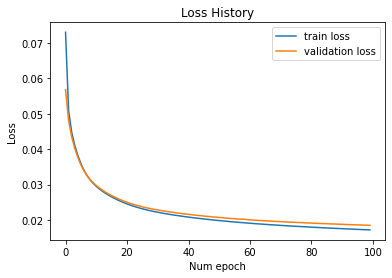

In [ ]:
import matplotlib.pyplot as plt
x_axis = np.arange(NUM_EPOCH)
fig, ax = plt.subplots()
ax.plot(x_axis, train_loss_history, label='train loss')
ax.plot(x_axis, valid_loss_history, label='validation loss')
ax.set_xlabel('Num epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
fig.show()

# **9. Generating SMILES with VAE**

In [ ]:
def index_list_to_smiles(ind_list, i_to_c):
    return "".join([i_to_c[x] for x in ind_list])


save_state_dict = torch.load(os.path.join(save_dir, f"save_{best_epoch}.pt"))
model.load_state_dict(save_state_dict)
model.eval()

max_length = 64
num_sample = 200
i_to_c = dataset._get_i_to_c()

gen_smis = []
for _ in tqdm(range(num_sample), total=num_sample):
    gen_smi = model.generate(max_length)
    gen_smis.append(index_list_to_smiles(gen_smi, i_to_c))

print(gen_smis)

100%|██████████| 200/200 [00:02<00:00, 97.54it/s]

['O=C1CCCCC1=O', 'c1ccc(-c2ccccc2)n1Cc1ccccc1', 'CC1(C)CC(=O)C2C(C#N)=C(N)O1', '', 'CC(=O)Nc1ccc(Cl)cc1Cl)c1ccccc1', 'CC(=O)OCCC(=O)O)c1ccccc1', 'CCOC(=O)CCC(=O)Nc1ccccc1', 'N=C/c1c(C)nc2ccccc21', 'O=C(Nc1ccccc1)c1ccccc1O', 'c1ccc(C2C(C#N)=C(N)OC2=O)cc1', 'O=C(NCCO)C(=O)NC1c1ccccc1', '', 'N=O', 'O=C(NCCO)C(=O)NC1c1ccccc1', 'nnn1[O-]', 'CC(C)CC(C)C)C(=O)NCCCCCCCCCCCC1CCCCC1', 'O=O)n1Cc1ccccc1', '', 'c2ccccc2C(=O)NC1c1ccccc1', 'c1ccc(-c2ccccc23)cc1', 'C=C(N)Oc1ccccc1)c1ccccc1', '', 'CC(=O)Nc1ccc(C(=O)Nc2ccccc2)cc1', 'c1c2ccccc2c2ccc(Cl)cc21', '#N#CC1CCCCC1', 'Cn1c(=O)[nH]c(=O)n2C', 'CC(C)CC(=O)NNC(=O)c1ccccc1', 'O=C(O)CCC(=O)Nc1ccccc1', 'O=C1CCCCC1', 'O=C(O)CC(C)(C)CC(=O)OCCOCCOCC1CCCCC1', 'CCOC(=O)C(NC(=O)c1ccccc1)c1ccccc1', 'c1ccccc1C(=O)Nc1ccccc1', 'CCOC(=O)CCC(=O)NCCCCCCCCCC1CCCCC1', 'O=C/C(C)=C/c1ccccc1)c1ccccc1', 'N#CC1=C(N)OC2=C(C(=O)CCC2)C1c1ccccc1', '', 'CCOC(=O)c2ccccc2)cc1', 'O=C1/C(=N/NC(=O)c2ccccc2)C(=O)N1CCOCC1', 'O=C(NCCO)C1CCCCCC1', 'c1ccccc1)c1ccccc1O', 'CC1CCCCC1=O', 'C

Number of valid SMILES: 83
Number of unique SMILES: 55
Number of novel SMILES: 54


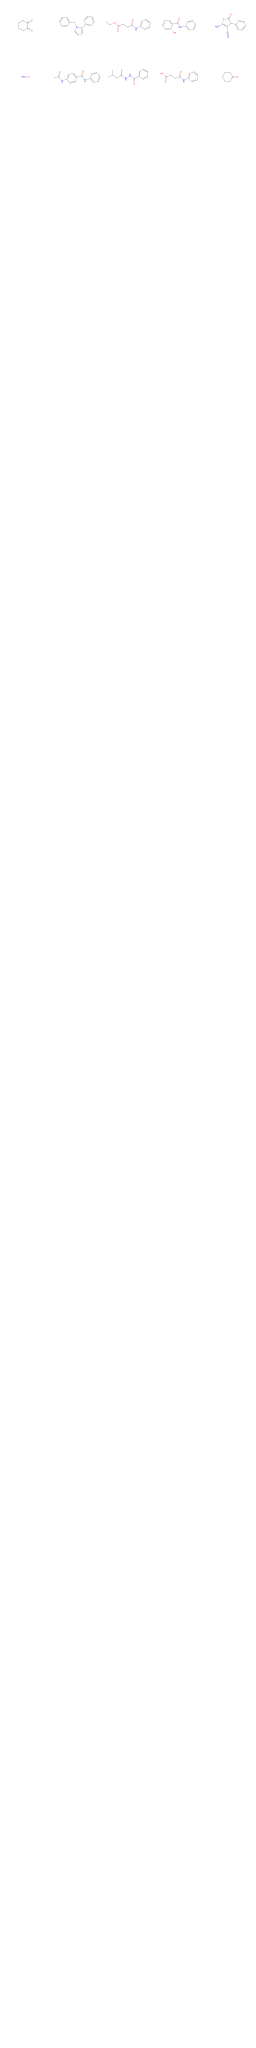

In [ ]:
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from IPython.display import SVG

def filter_smiles(smi_list, ref_smi_list=None):

    # 1. Valid smiles?
    valid_smi_list = []
    for smi in smi_list:
        if len(smi) == 0: continue
        try: 
            mol = Chem.MolFromSmiles(smi)
            assert mol is not None
        except:
            continue
        valid_smi_list.append(smi)

    # 2. Unique smiles?
    unique_smi_list = []
    for smi in valid_smi_list:
        if smi not in unique_smi_list:
          unique_smi_list.append(smi)
        

    # 3. Novel smiles?
    novel_smi_list = []
    for smi in unique_smi_list:
        if smi not in train_dataset.smi_list:
          novel_smi_list.append(smi)
        

    return valid_smi_list, unique_smi_list, novel_smi_list

filtered_gen_smis_val = filter_smiles(gen_smis)[0]
filtered_gen_smis_uni = filter_smiles(gen_smis)[1]
filtered_gen_smis_nov = filter_smiles(gen_smis)[2]
print("Number of valid SMILES:", len(filtered_gen_smis_val))
print("Number of unique SMILES:", len(filtered_gen_smis_uni))
print("Number of novel SMILES:", len(filtered_gen_smis_nov))

mols = [Chem.MolFromSmiles(smi) for smi in filtered_gen_smis_nov][:10]

mols_per_row = 5
mols_per_column = num_sample // mols_per_row
size = 300
min_font_size = 12

d2d = rdMolDraw2D.MolDraw2DSVG(mols_per_row*size, mols_per_column*size, size, size)
d2d.drawOptions().minFontSize = min_font_size
d2d.drawOptions().scaleBondWidth = True
d2d.DrawMolecules(mols)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())



In [ ]:
print("validity = ", len(filtered_gen_smis_val)/len(gen_smis) )
print("uniqueness = ", len(filtered_gen_smis_uni)/len(filtered_gen_smis_val))
print("novelty = ", len(filtered_gen_smis_nov)/len(filtered_gen_smis_uni))

validity =  0.415
uniqueness =  0.6626506024096386
novelty =  0.9818181818181818
